In [157]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

Simple logistic regression

In [158]:
data = pd.read_csv('data/ML_DATA_MXF.csv')
data.dropna(inplace= True)

true_label = data.BINARY_PHENOTYPE

features = ['d_volume', 'd_hydropathy_KD', 'd_hydropathy_WW',
       'd_MW', 'd_Pi', 'secondary_structure', 'phi', 'psi', 'residue_sasa', 
       'n_hbond_acceptors', 'n_hbond_donors', 'SASA', 'snap2_score', 'dist_MGB', 'dist_MGE', 'dist_MFX'] # 'B', 'C', 'E', 'G', 'H', 'T',

features = data[features]
features['secondary_structure_codes'] = pd.Categorical(features.secondary_structure, categories=features.secondary_structure.unique()).codes
features.drop('secondary_structure', inplace = True, axis = 1)

true_label
features

/var/folders/nq/gpbdk7y11kvd1d9nk9s77b4c0000gn/T/ipykernel_10622/3423287689.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['secondary_structure_codes'] = pd.Categorical(features.secondary_structure, categories=features.secondary_structure.unique()).codes
/var/folders/nq/gpbdk7y11kvd1d9nk9s77b4c0000gn/T/ipykernel_10622/3423287689.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop('secondary_structure', inplace = True, axis = 1)


,d_volume,d_hydropathy_KD,d_hydropathy_WW,d_MW,d_Pi,phi,psi,residue_sasa,n_hbond_acceptors,n_hbond_donors,SASA,snap2_score,dist_MGB,dist_MGE,dist_MFX,secondary_structure_codes
0,-51.0,3.1,-1.27,-58.0,3.20,-58.04,-41.61,97.4,1.0,1.0,88.155089,63,18.494689,7.838828,14.503318,0
1,51.4,2.4,-0.86,28.0,-0.04,-61.83,-59.76,47.0,2.0,0.0,55.555816,-64,14.434102,5.483332,10.609526,0
2,3.0,0.0,-1.98,-1.0,2.64,-58.04,-41.61,97.4,1.0,1.0,88.155089,56,18.494689,7.838828,14.503318,0
3,-51.0,3.1,-1.27,-58.0,3.20,-58.04,-41.61,97.4,1.0,1.0,88.155089,63,18.494689,7.838828,14.503318,0
4,3.0,0.0,-1.98,-1.0,2.64,-58.04,-41.61,97.4,1.0,1.0,88.155089,56,18.494689,7.838828,14.503318,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1664,23.7,-0.8,-0.64,10.0,0.62,-67.15,-27.15,64.8,1.0,0.0,65.228155,63,13.712391,5.381126,11.010229,0
1665,51.4,2.4,-0.86,28.0,-0.04,-61.83,-59.76,47.0,2.0,0.0,55.555816,-64,14.434102,5.483332,10.609526,0
1666,51.4,2.4,-0.86,28.0,-0.04,-61.83,-59.76,47.0,2.0,0.0,55.555816,-64,14.434102,5.483332,10.609526,0
1667,113.3,-4.1,-0.14,99.1,4.79,-61.79,-46.23,2.4,3.0,1.0,2.551348,33,29.300727,43.081517,41.932227,0


In [159]:
random_seed = 144

X_train,X_test,y_train,y_test=train_test_split(features,true_label,test_size=0.20,random_state = random_seed) 

In [160]:
random_seed = 144

folds = StratifiedKFold(n_splits = 10, random_state = random_seed, shuffle = True)

param_grid = [ 
                {   'penalty': ['l2'],
                    'solver'  : ['newton-cg', 'lbfgs', 'liblinear', 'newton-cholesky', 'sag', 'saga'], 
                    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    'class_weight' : ['balanced', None]
                } 
            ]

gsvc = GridSearchCV(LogisticRegression(random_state=random_seed), param_grid, cv = folds, scoring = 'f1') #, scoring='f1' , scoring = 'recall'

In [161]:
gsvc.fit(X_train,y_train)
gsvc.cv_results_

/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/predict_FQ_resistance/predict_FQ_resistance/.venv_fq/lib/python3.10/site-packages/sk

{'mean_fit_time': array([0.03848305, 0.02106397, 0.00675223, 0.00633767, 0.02605181,
        0.03387668, 0.03355067, 0.02003169, 0.00619071, 0.00547364,
        0.02367256, 0.02463124, 0.04138384, 0.01938782, 0.00784202,
        0.00636668, 0.02343464, 0.02499642, 0.03489027, 0.01854696,
        0.00776882, 0.00564399, 0.02292259, 0.02801373, 0.0453192 ,
        0.01916757, 0.00976005, 0.00662854, 0.02318738, 0.02473662,
        0.03628361, 0.01849768, 0.00944231, 0.00670102, 0.02382824,
        0.02505813, 0.05076349, 0.01944442, 0.01253378, 0.00655775,
        0.02303412, 0.02503369, 0.04171376, 0.01911895, 0.01166031,
        0.00565517, 0.02328658, 0.02457697, 0.05783927, 0.01909709,
        0.01552403, 0.00678241, 0.02318957, 0.02475793, 0.04474163,
        0.01889343, 0.01904383, 0.00615764, 0.02402949, 0.02557616,
        0.05768719, 0.02062037, 0.01666222, 0.00705881, 0.03011827,
        0.02706032, 0.0443228 , 0.02130501, 0.01459126, 0.00590875,
        0.02959218, 0.02541215,

In [162]:
df = pd.DataFrame(gsvc.cv_results_)
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_class_weight', 'param_penalty', 'param_solver',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'split5_test_score',
       'split6_test_score', 'split7_test_score', 'split8_test_score',
       'split9_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [163]:
gsvc.best_params_

{'C': 0.001,
 'class_weight': 'balanced',
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [164]:
gsvc.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', random_state=144,
                   solver='newton-cg')

In [165]:
logreg =  LogisticRegression(solver='newton-cg', random_state=random_seed, class_weight = 'balanced', C = 0.001, penalty = 'l2') 

In [166]:
logreg.fit(X_train,y_train) 

LogisticRegression(C=0.001, class_weight='balanced', random_state=144,
                   solver='newton-cg')

In [167]:
y_pred=logreg.predict(X_test) 

In [168]:
y_df = pd.DataFrame(y_pred)
y_df.value_counts()

R    268
S     62
Name: count, dtype: int64

In [169]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred) 

cnf_matrix 

array([[255,  17],
       [ 13,  45]])

Text(0.5, 427.9555555555555, 'Predicted label')

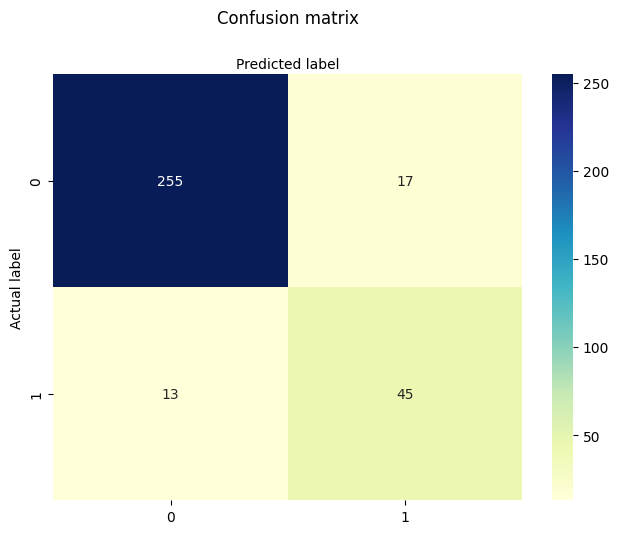

In [170]:
class_names=[0,1] # name  of classes 

fig, ax = plt.subplots() 

tick_marks = np.arange(len(class_names)) 

plt.xticks(tick_marks, class_names) 

plt.yticks(tick_marks, class_names) 

# create heatmap 

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g') 

ax.xaxis.set_label_position("top") 

plt.tight_layout() 

plt.title('Confusion matrix', y=1.1) 

plt.ylabel('Actual label') 

plt.xlabel('Predicted label')

In [171]:
sensitivity = cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])
specificity = cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[0,1])
print(sensitivity, specificity)

0.7758620689655172 0.9375
